In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import skew, kurtosis
import seaborn as sns
sns.set()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from matplotlib.backends import backend_pdf
import sweetviz as sv
from simpful import (
    FuzzySet,
    FuzzySystem,
    LinguisticVariable,
    AutoTriangle,
    Sigmoid_MF,
    InvSigmoid_MF,
    Gaussian_MF,
    InvGaussian_MF,
)

FS = 64

LABELS = {'Poor': -1, 'Medium': 0, 'Good': 1}
COLORS = ['red', 'blue', 'green']
annotators = ['Tomek', 'Karolina', 'Janek']

In [2]:
tomek_results = pd.read_csv('../data/Tomek/results.csv', index_col=0)
karo_results = pd.read_csv('../data/Karo/results.csv', index_col=0)
janek_results = pd.read_csv('../data/Janek/results.csv', index_col=0)

results = pd.concat([tomek_results, karo_results, janek_results]).reset_index(drop=True)
results['rating'] = results['label'].apply(lambda label: LABELS[label])

tomek_signals = [pd.read_csv(f"../data/Tomek/samples/{sample_num}.csv", index_col=0).bvp.values for sample_num in range(len(tomek_results))]
karo_signals = [pd.read_csv(f"../data/Karo/samples/{sample_num}.csv", index_col=0).bvp.values for sample_num in range(len(karo_results))]
janek_signals = [pd.read_csv(f"../data/Janek/samples/{sample_num}.csv", index_col=0).bvp.values for sample_num in range(len(janek_results))]

signals = [*tomek_signals, *karo_signals, *janek_signals]

In [3]:
tomek_results = pd.read_csv('../data/Tomek/results.csv', index_col=0)
tomek_results['rating'] = tomek_results['label'].apply(lambda label: LABELS[label])
tomek_signals = [pd.read_csv(f"../data/Tomek/samples/{sample_num}.csv", index_col=0).bvp.values for sample_num in range(len(tomek_results))]

In [4]:
example_signals = [pd.read_csv(f"../data/examples/{sample_num}.csv", index_col=0).bvp.values for sample_num in range(40)]

In [5]:
def save_figs_to_pdf(*figs, path):
    pdf = backend_pdf.PdfPages(path)
    for fig in figs:
        pdf.savefig(fig)
    pdf.close()
    

def entropy(data):
    squared_data = data ** 2
    return -(squared_data * np.log(squared_data)).sum() / len(squared_data)


def find_zero_cross(data):      
    zero_cross = np.sign(np.diff(np.sign(data)))
    positive = np.where(zero_cross == 1)[0]  # from minut to plus
    negative = np.where(zero_cross == -1)[0]  # from plus to minus
    return positive, negative


def get_zero_cross_features(data):
    n_samples = len(data)
    new_n_samples = n_samples * 100
    t = np.linspace(0, n_samples/FS, n_samples, endpoint=False)
    interp_fn = interpolate.interp1d(t, data, fill_value="extrapolate")
    t_new = np.linspace(0, n_samples/FS, new_n_samples, endpoint=False)
    data_interp = interp_fn(t_new)
    positive_zc, negative_zc = find_zero_cross(data_interp)
    positive_zc_times = t_new[positive_zc]
    negative_zc_times = t_new[negative_zc]    
    
    positive_zc_intervals = np.diff(positive_zc_times)
    negative_zc_intervals = np.diff(negative_zc_times)
    
    zero_cross_features = {
        'positive_zc_intervals_mean': positive_zc_intervals.mean(),
        'positive_zc_intervals_std': positive_zc_intervals.std(),
        'negative_zc_intervals_mean': negative_zc_intervals.mean(),
        'negative_zc_intervals_std': negative_zc_intervals.std(),
        
    }
    return zero_cross_features


def get_quality_features(data):
    data_standardized = (data - data.mean()) / data.std()
    quality_features = {
        'std': np.std(data),
        'skew': skew(data_standardized),
        'kurtosis': kurtosis(data_standardized),
        'entropy': entropy(data_standardized),
        **get_zero_cross_features(data_standardized)
    }
    return quality_features


def get_windows(start, max_len, win_len, step):
    end = start + win_len
    windows = []
    while end < max_len:
        windows.append((start, end))
        start += step
        end += step
    windows.append(np.array([start, max_len]))
    return np.array(windows)


def train_model(features_df, ModelClass=RandomForestClassifier, model_params={}):
    X = features_df.drop('label', axis=1).values
    y = features_df['label'].values
    
    model = ModelClass(**model_params)
    model.fit(X, y)
    return model


def rate_signal(signal, signal_quality_model, win_len=5, step=1, plot=True):
    signal_df = pd.DataFrame(data=signal, index=np.linspace(0, len(signal)/FS, len(signal), endpoint=False), columns=['data'])
    windows = get_windows(0, signal_df.index[-1], win_len, step)
    signal_slices = [signal_df.loc[start:end].values.flatten() for start, end in windows]
    signal_features = [{
        **get_quality_features(data),
        'start': start,
        'end': end
    } for data, (start, end) in zip(signal_slices, windows)]
    signal_features_df = pd.DataFrame(signal_features)#.dropna()
    imputer = SimpleImputer()
    features_array = imputer.fit_transform(signal_features_df.drop(['start', 'end'], axis=1).values)
    signal_slices_labels = signal_quality_model.predict(features_array)
    signal_features_df['label'] = signal_slices_labels
    if plot:
        sig_range = signal.max() - signal.min()
        margin = 0.05 * sig_range
        lower_bound, upper_bound = signal.min() - margin, signal.max() + margin

        fig, ax = plt.subplots(figsize=(24, 5))
        ax.plot(signal_df.index, signal_df.data, color='black', lw=3)
        for label, (start, end) in zip(signal_slices_labels, windows):
            ax.fill_between([start, end], lower_bound, upper_bound, alpha=0.05, color=COLORS[label+1])

        ax.set_ylim([lower_bound, upper_bound])
        ax.set_xlim([0, 100])
        
        return fig
    return signal_features_df

In [6]:
features_df = pd.DataFrame([get_quality_features(signal) for signal in signals])#.dropna()
features_df['label'] = results['rating']
features_df = features_df.dropna()

/tmp/ipykernel_28383/2546656397.py:35: RuntimeWarning: Mean of empty slice.
  'positive_zc_intervals_mean': positive_zc_intervals.mean(),
/home/jslowik/.pyenv/versions/3.8.13/envs/fuzzy_bvp_labeler/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jslowik/.pyenv/versions/3.8.13/envs/fuzzy_bvp_labeler/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jslowik/.pyenv/versions/3.8.13/envs/fuzzy_bvp_labeler/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jslowik/.pyenv/versions/3.8.13/envs/fuzzy_bvp_labeler/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  

In [7]:
features_df.head()

std      skew   kurtosis   entropy  positive_zc_intervals_mean  \
0   42.584512 -0.165515  -1.094747 -0.468760                    0.733190   
1   24.897877 -3.730491  21.877528 -2.655810                    0.894883   
2   93.554878  1.372042   5.975955 -1.527539                    0.509444   
3  300.312335 -0.353367  -0.386150 -0.657215                    1.488229   
4   10.273590  1.187592   3.309365 -1.240033                    0.511209   

   positive_zc_intervals_std  negative_zc_intervals_mean  \
0                   0.156138                    0.737200   
1                   0.814688                    1.093247   
2                   0.189116                    0.511012   
3                   0.813098                    1.389156   
4                   0.294348                    0.510263   

   negative_zc_intervals_std  label  
0                   0.113789      1  
1                   1.059997     -1  
2                   0.184393     -1  
3                   0.652157     -1  
4                   0.330283     -1

In [8]:
# report = sv.analyze(features_df)
# report.show_html('ppg_signal_features.html') 

In [9]:
features_df.columns

Index(['std', 'skew', 'kurtosis', 'entropy', 'positive_zc_intervals_mean',
       'positive_zc_intervals_std', 'negative_zc_intervals_mean',
       'negative_zc_intervals_std', 'label'],
      dtype='object')

# fuzzy cls

In [10]:
class FuzzyQualityModel:
    def __init__(self):
        self.fs = FuzzySystem()
        
        # altenatywnie jak inaczej definiowac zmienne
        # sex_male = FuzzySet(function=Sigmoid_MF(c=0.5, a=0.1), term="male")
        # sex_female = FuzzySet(function=InvSigmoid_MF(c=0.5, a=0.1), term="female")
        # LV1 = LinguisticVariable([sex_male,sex_female], concept="sex", universe_of_discourse=[0,1])
        # FS.add_linguistic_variable("sex", LV1)
        
        # std
        std_LV = AutoTriangle(3, terms=['low', 'medium', 'high'], universe_of_discourse=[0, 755])
        self.fs.add_linguistic_variable("std", std_LV)
        
        
        # skew
        skew_LV = AutoTriangle(3, terms=['low', 'medium', 'high'], universe_of_discourse=[-6.3, 4.9])
        self.fs.add_linguistic_variable("skew", skew_LV)
        
        
        # kurtosis
        kurtosis_LV = AutoTriangle(3, terms=['low', 'medium', 'high'], universe_of_discourse=[-1.5, 42.4])
        self.fs.add_linguistic_variable("kurtosis", kurtosis_LV)
        
        
        # entropy
        entropy_LV = AutoTriangle(3, terms=['low', 'medium', 'high'], universe_of_discourse=[-3.43, 0.33])
        self.fs.add_linguistic_variable("entropy", entropy_LV)
        
        
        # positive_zc_intervals_mean
        positive_zc_intervals_mean_LV = AutoTriangle(3, terms=['low', 'medium', 'high'], universe_of_discourse=[0.17, 2.19])
        self.fs.add_linguistic_variable("positive_zc_intervals_mean", positive_zc_intervals_mean_LV)
        
        
        # positive_zc_intervals_std
        positive_zc_intervals_std_LV = AutoTriangle(3, terms=['low', 'medium', 'high'], universe_of_discourse=[0.01, 2.68])
        self.fs.add_linguistic_variable("positive_zc_intervals_std", positive_zc_intervals_std_LV)
        
        
        # negative_zc_intervals_mean
        negative_zc_intervals_mean_LV = AutoTriangle(3, terms=['low', 'medium', 'high'], universe_of_discourse=[0.17, 2.17])
        self.fs.add_linguistic_variable("negative_zc_intervals_mean", negative_zc_intervals_mean_LV)
        
        
        # negative_zc_intervals_std
        negative_zc_intervals_std_LV = AutoTriangle(3, terms=['low', 'medium', 'high'], universe_of_discourse=[0.01, 1.8])
        self.fs.add_linguistic_variable("negative_zc_intervals_std", negative_zc_intervals_std_LV)
        
        # define consequencets
        self.fs.set_crisp_output_value("low", -1)
        self.fs.set_crisp_output_value("medium", 0)
        self.fs.set_crisp_output_value("high", 1)
        
    def fit(self, X_train, y_train):
        self.fs.add_rules([
            "IF (entropy IS high) THEN (quality IS low)",
            "IF (entropy IS low) THEN (quality IS high)",
        ])
        
    def _predict_per_row(self, features):
        # todo: check order of features
        self.fs.set_variable("std",                        features[0])
        self.fs.set_variable("skew",                       features[1])
        self.fs.set_variable("kurtosis",                   features[2])
        self.fs.set_variable("entropy",                    features[3])
        self.fs.set_variable("positive_zc_intervals_mean", features[4])
        self.fs.set_variable("positive_zc_intervals_std",  features[5])
        self.fs.set_variable("negative_zc_intervals_mean", features[6])
        self.fs.set_variable("negative_zc_intervals_std",  features[7])
        
        quality_inference = self.fs.inference()
        
        fuzzy_quality =  quality_inference['quality']
        
        return round(fuzzy_quality)
        
        
    
    def predict(self, X_test):
        WTF = X_test.copy()
        
        y_pred = np.apply_along_axis(self._predict_per_row, 1, WTF)
        
        return y_pred



In [11]:
# signal_qality_model = train_model(features_df, RandomForestClassifier)
signal_qality_model = train_model(features_df, FuzzyQualityModel)

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.6.3 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

 * Detected Sugeno model type


/tmp/ipykernel_28383/2546656397.py:35: RuntimeWarning: Mean of empty slice.
  'positive_zc_intervals_mean': positive_zc_intervals.mean(),
/home/jslowik/.pyenv/versions/3.8.13/envs/fuzzy_bvp_labeler/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jslowik/.pyenv/versions/3.8.13/envs/fuzzy_bvp_labeler/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jslowik/.pyenv/versions/3.8.13/envs/fuzzy_bvp_labeler/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jslowik/.pyenv/versions/3.8.13/envs/fuzzy_bvp_labeler/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  

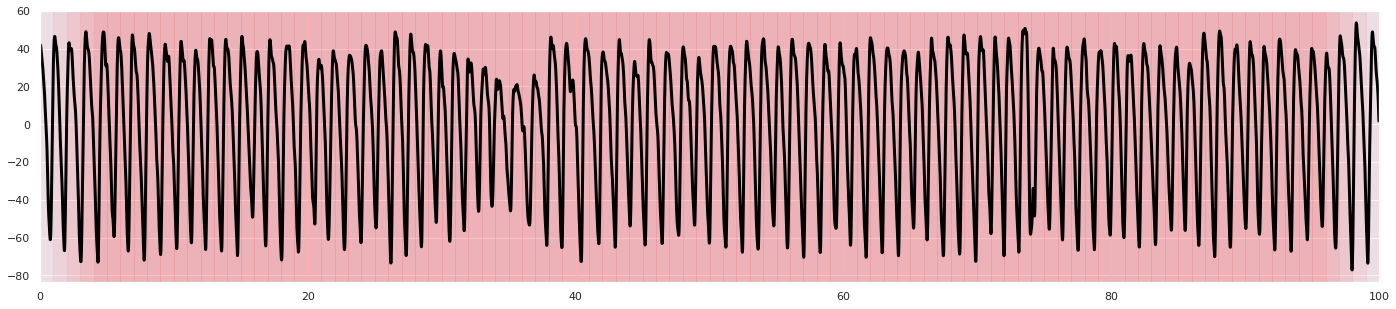

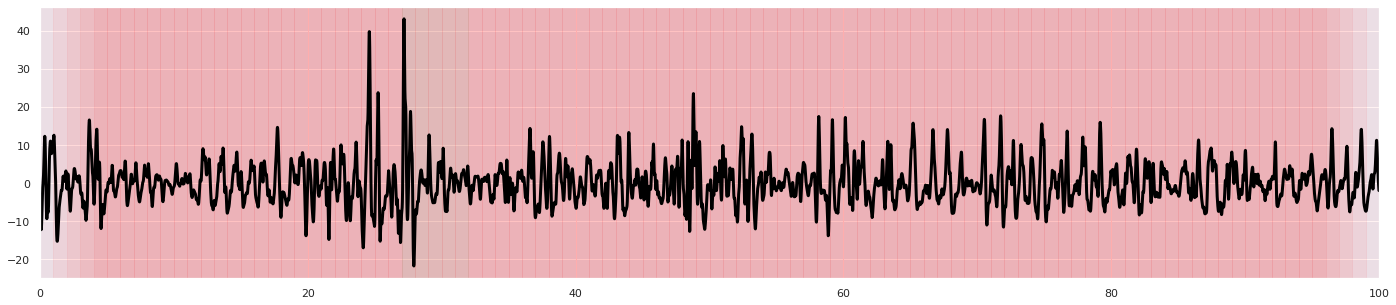

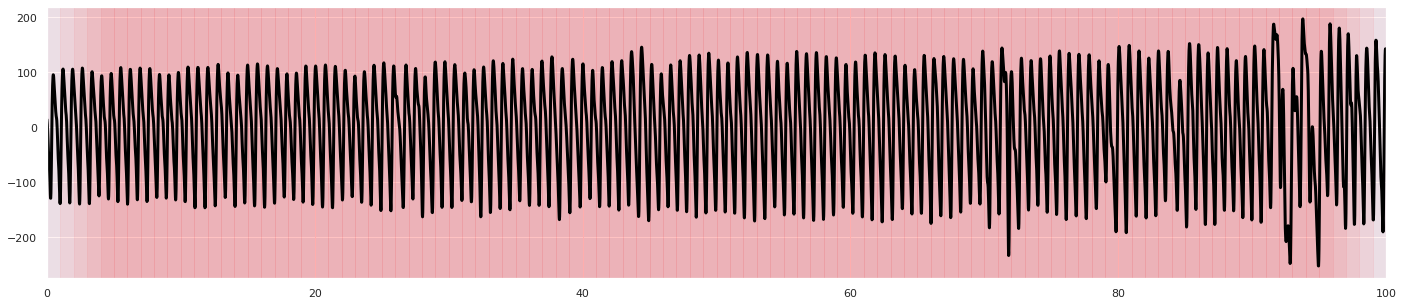

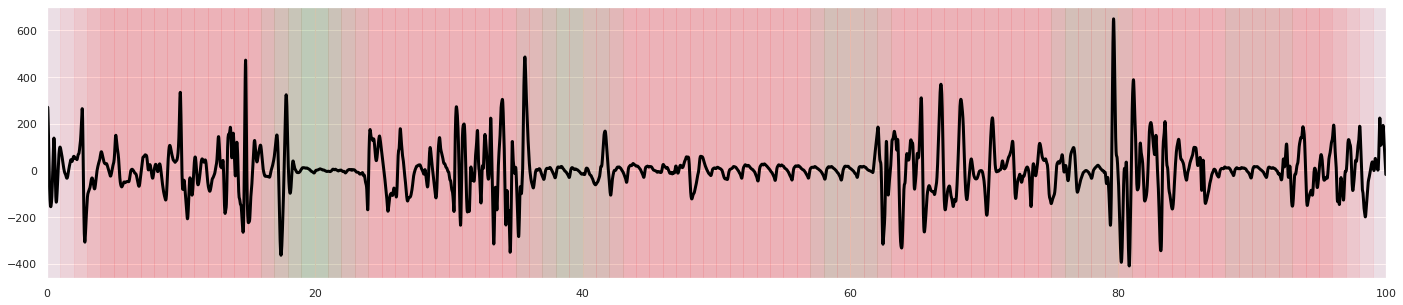

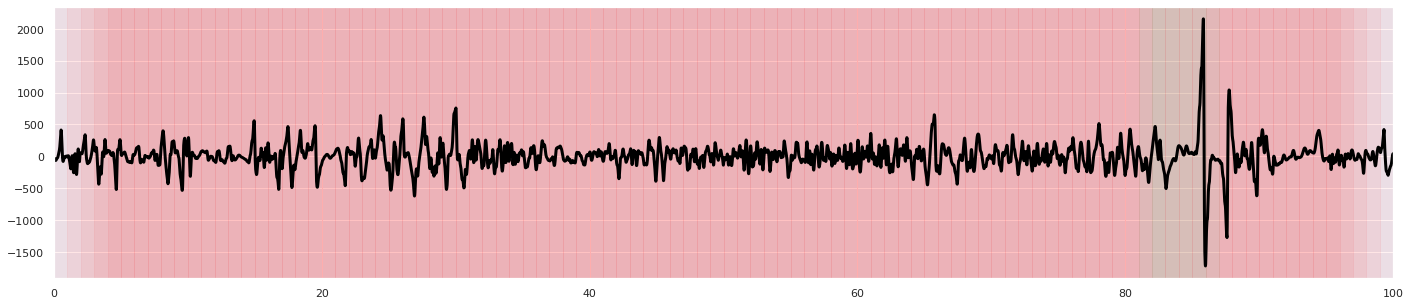

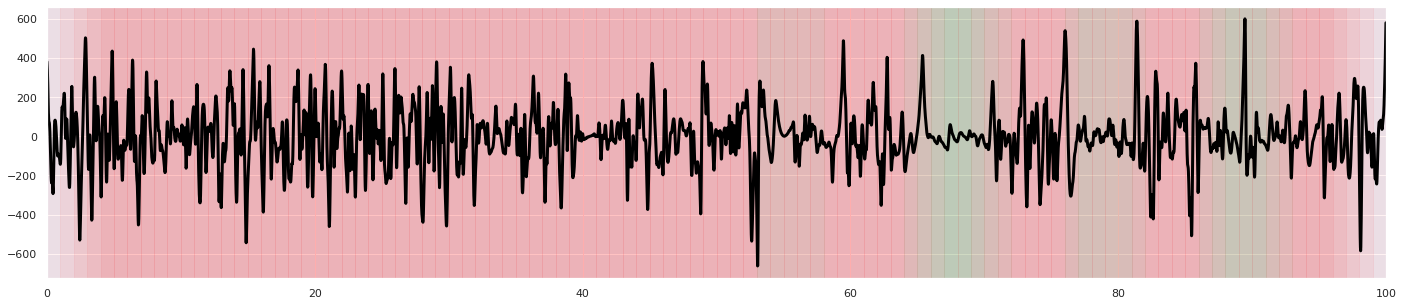

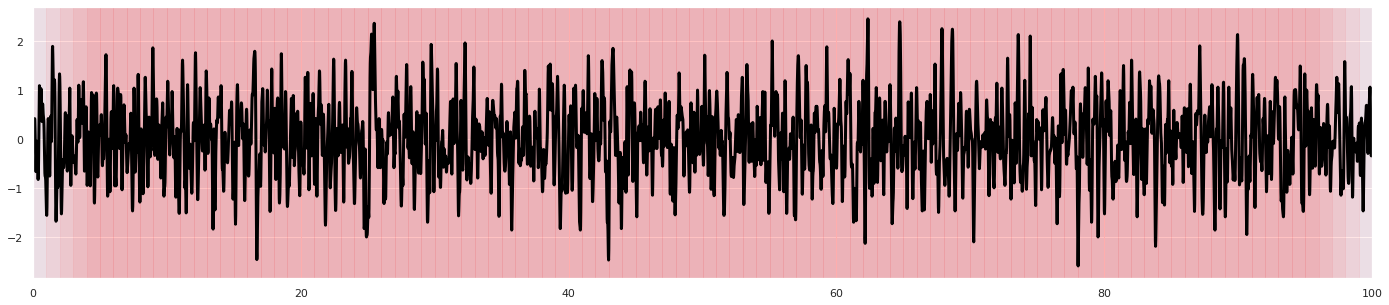

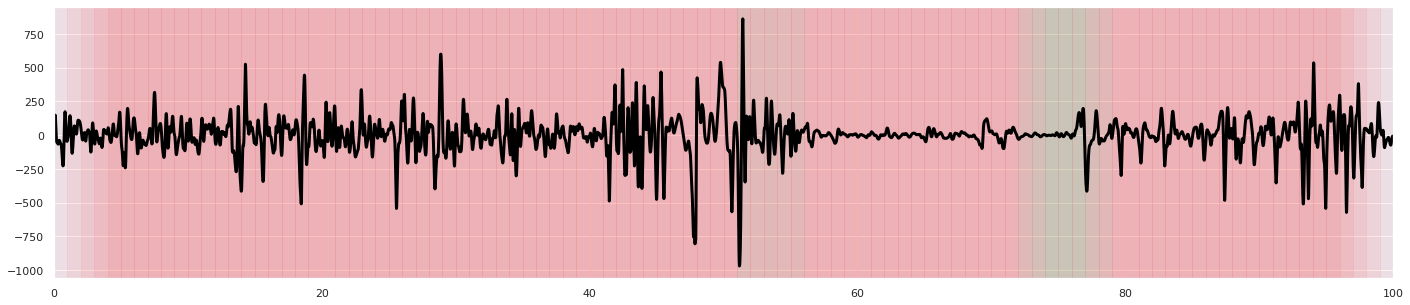

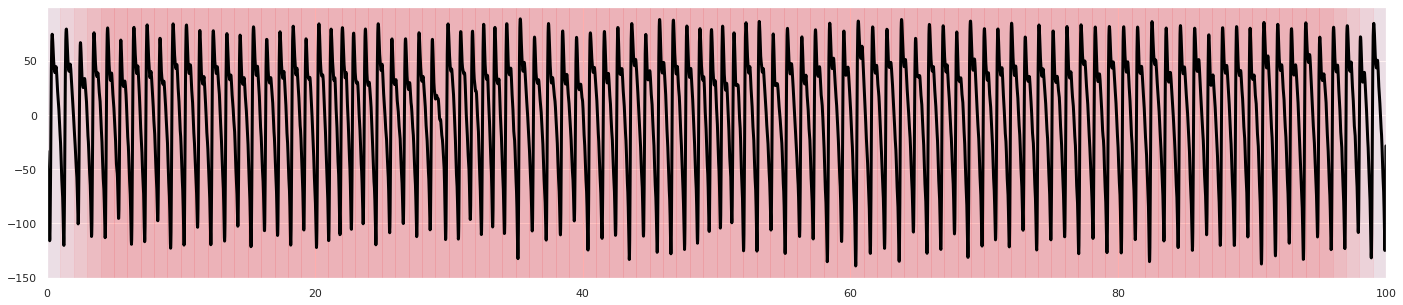

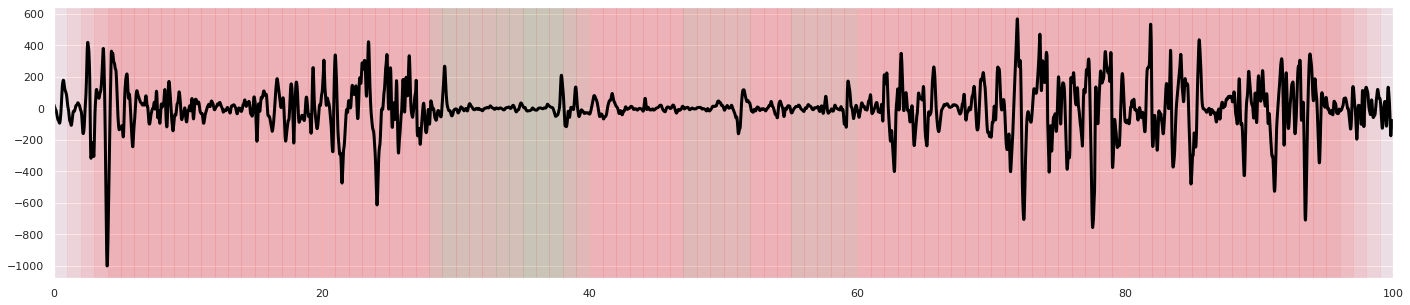

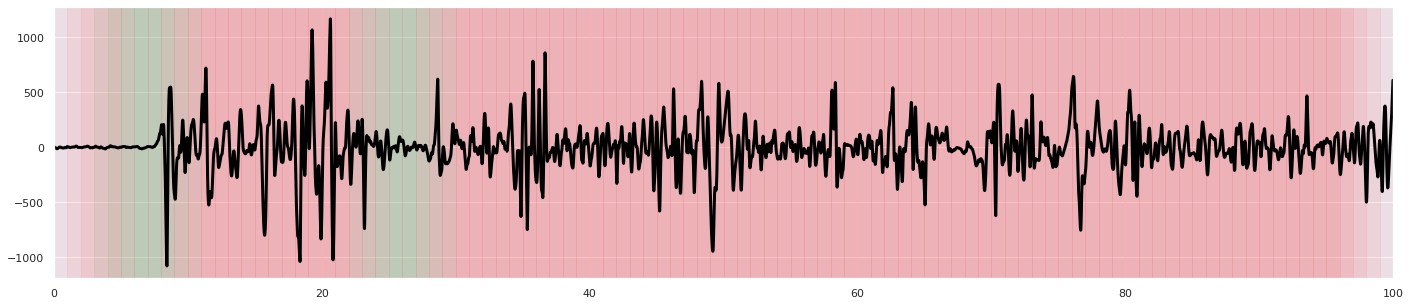

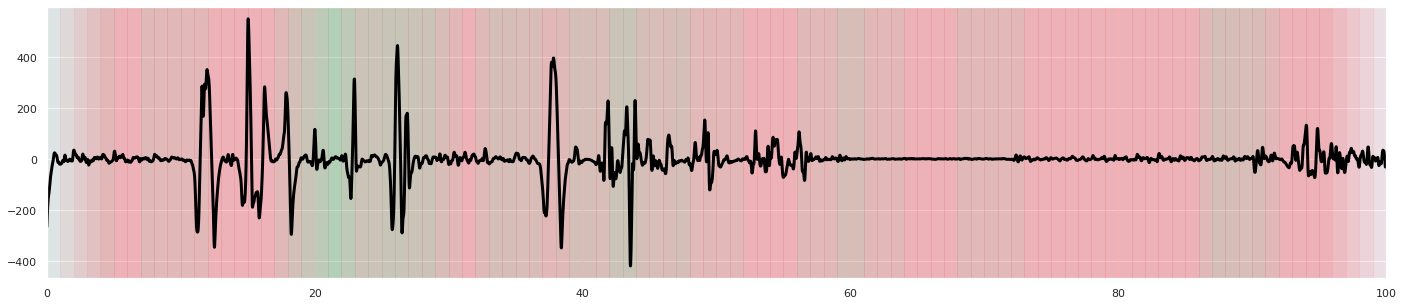

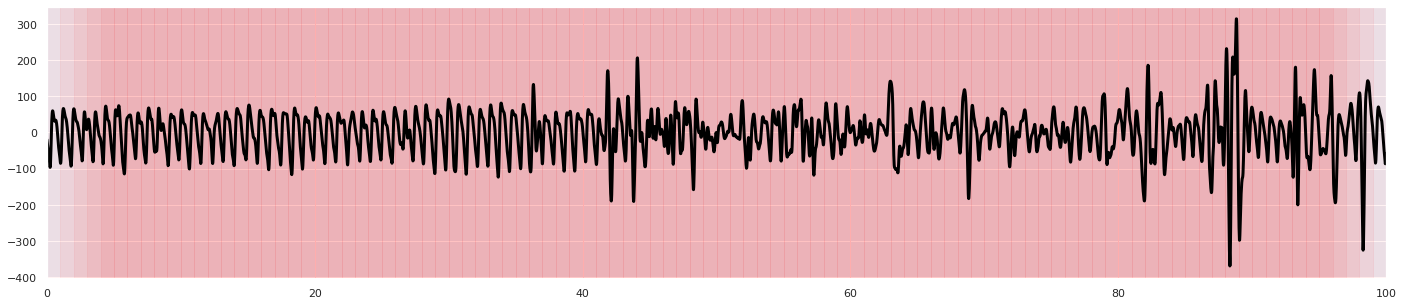

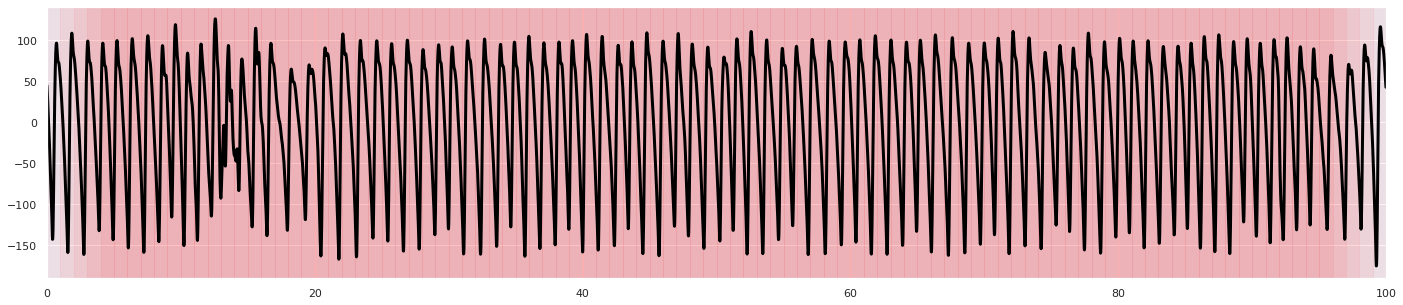

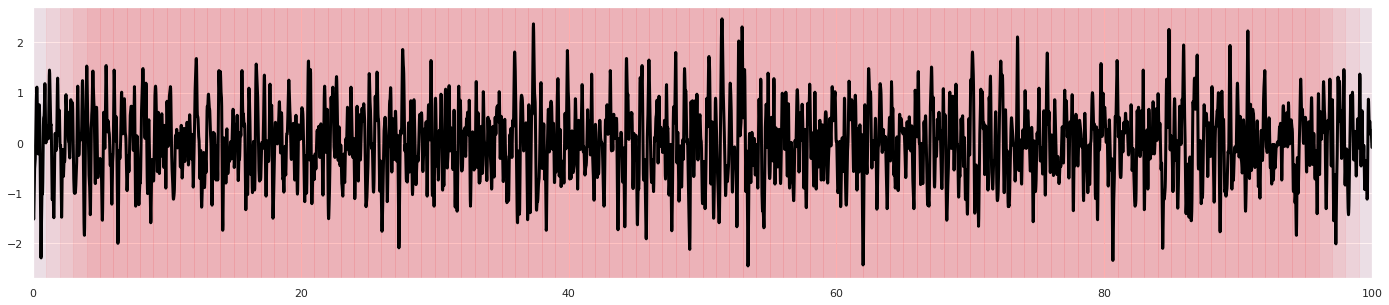

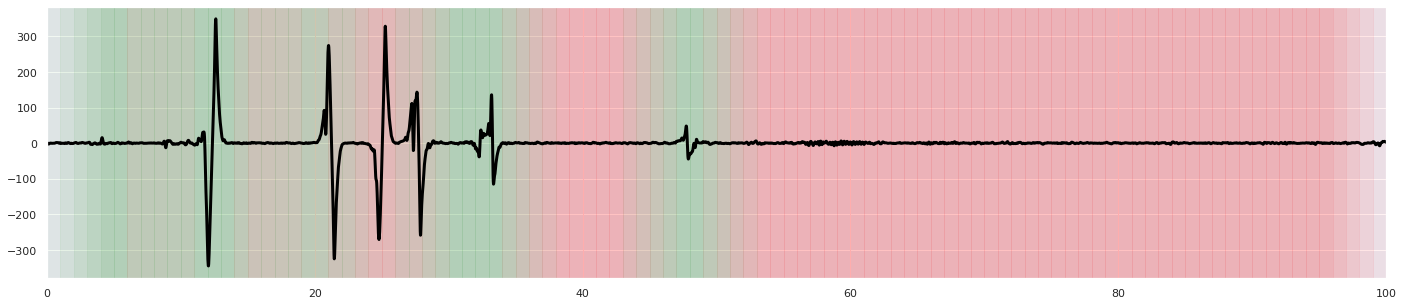

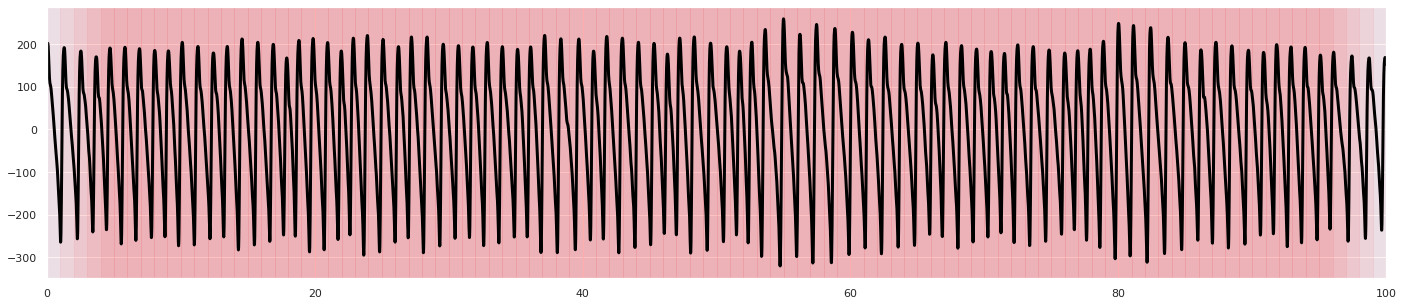

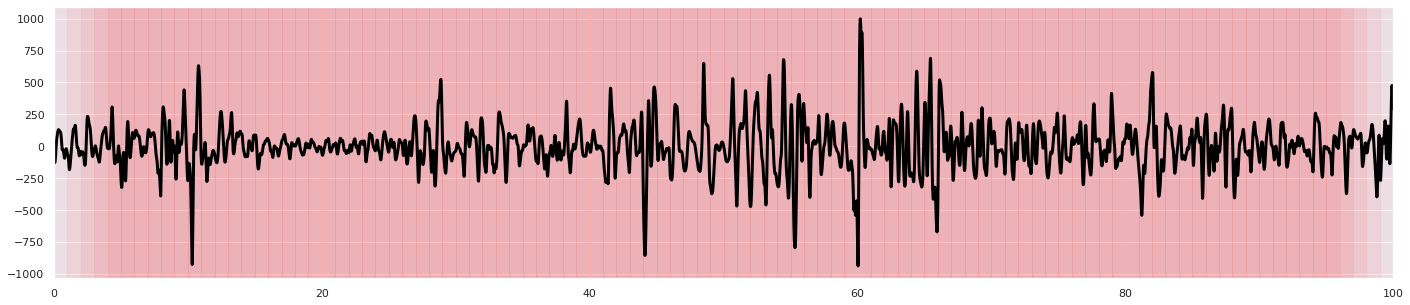

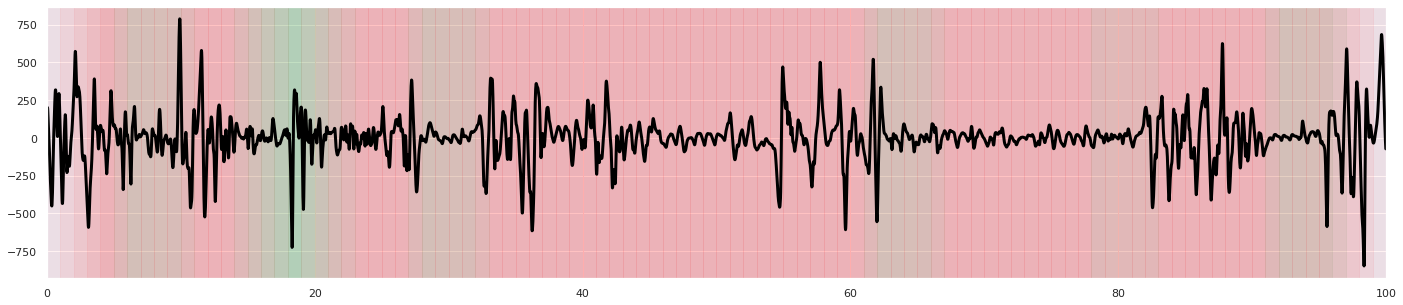

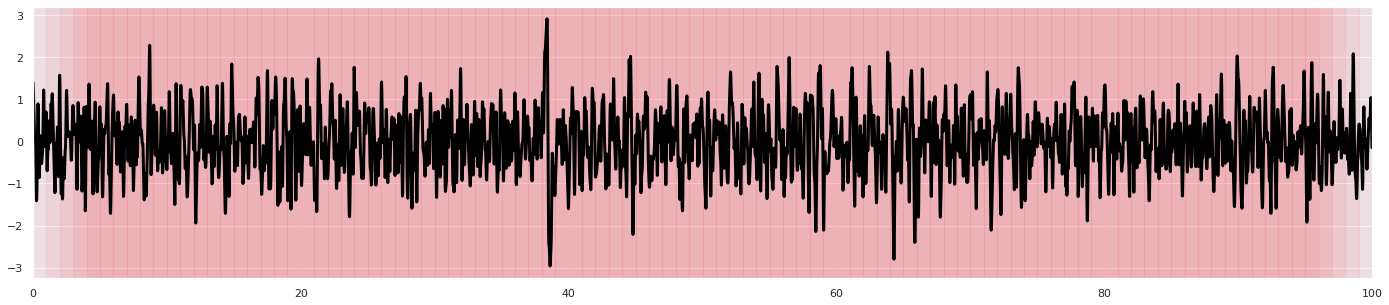

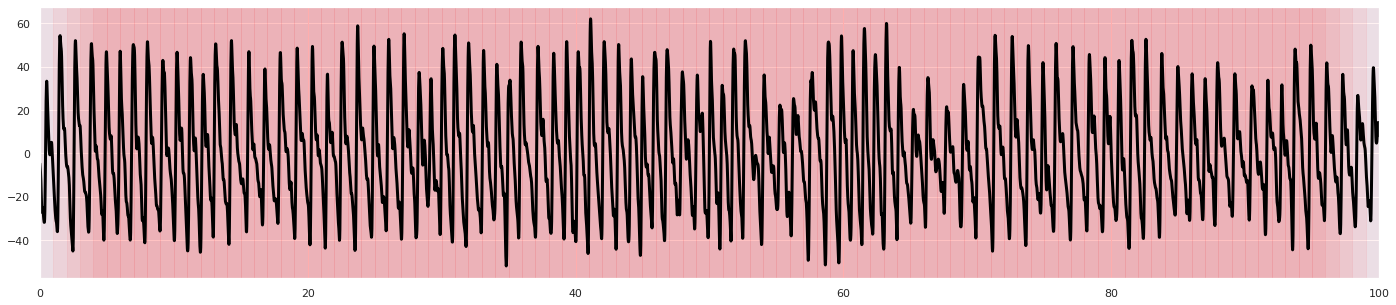

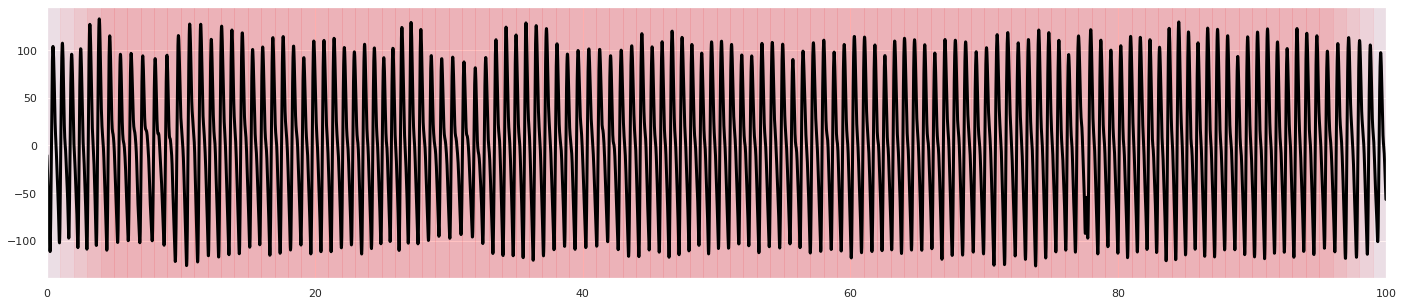

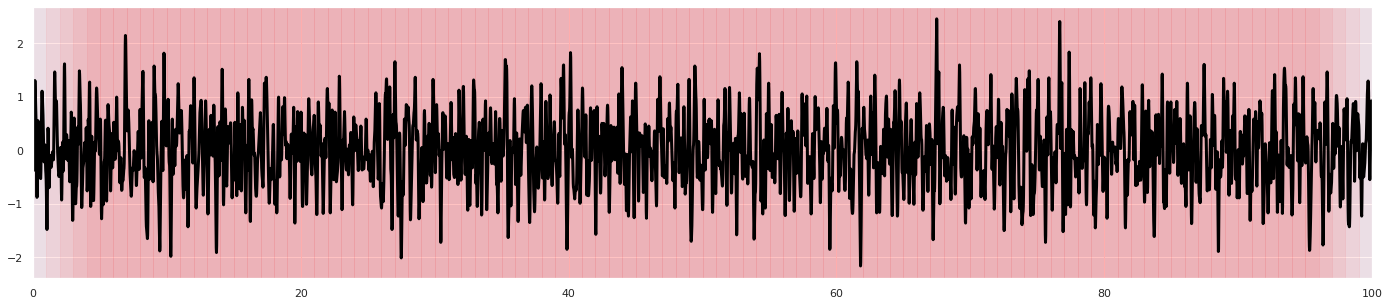

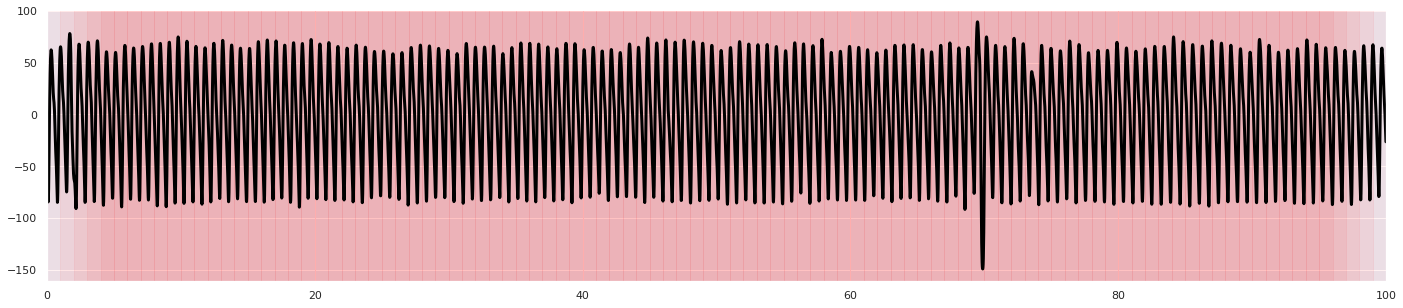

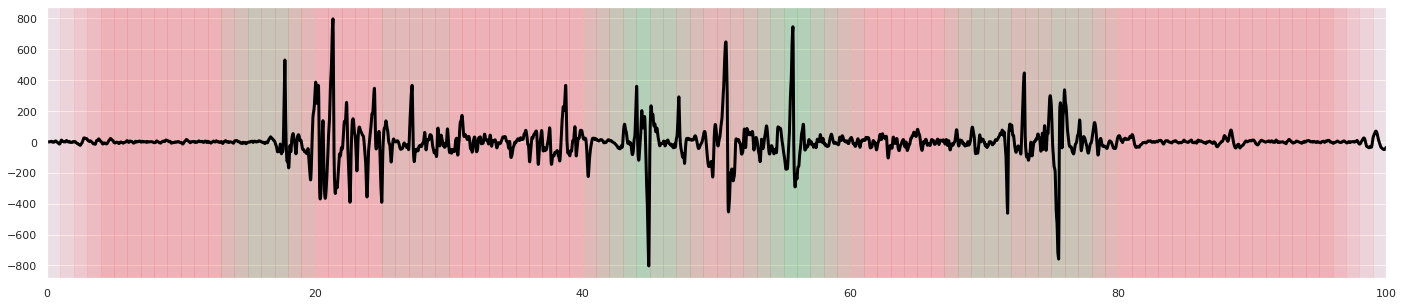

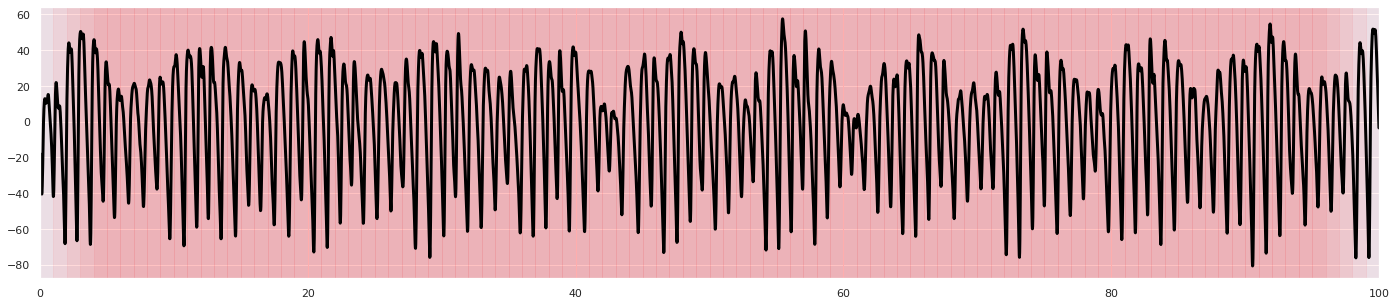

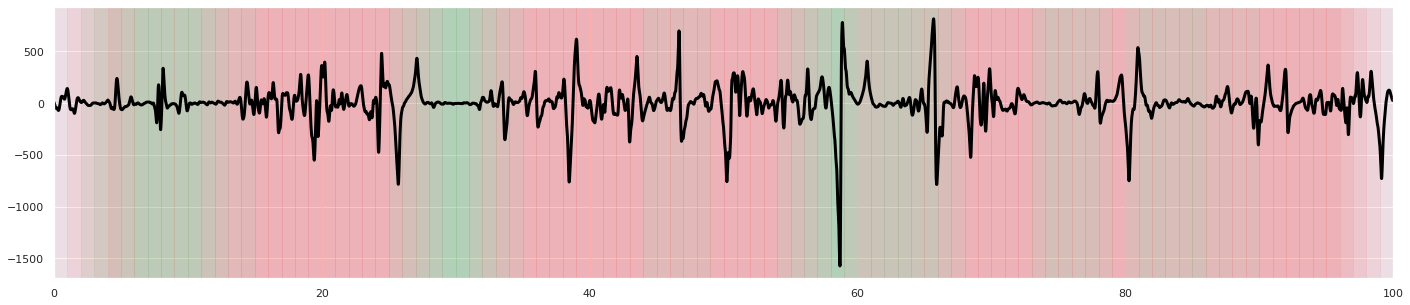

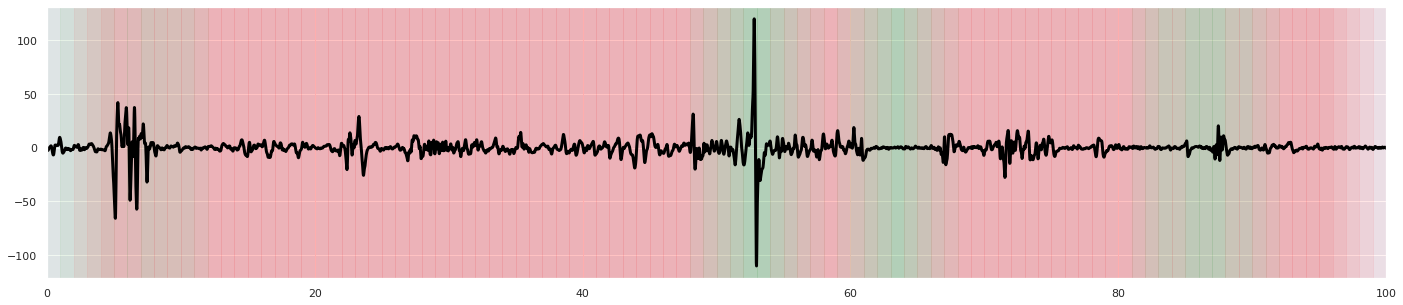

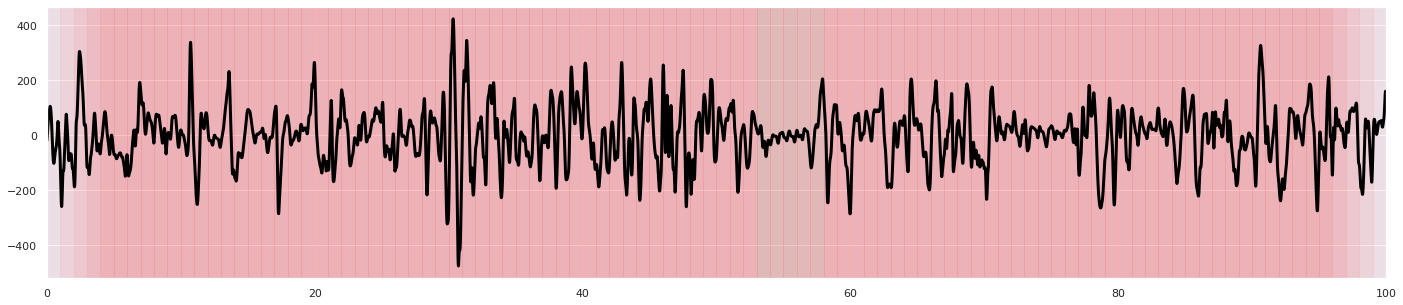

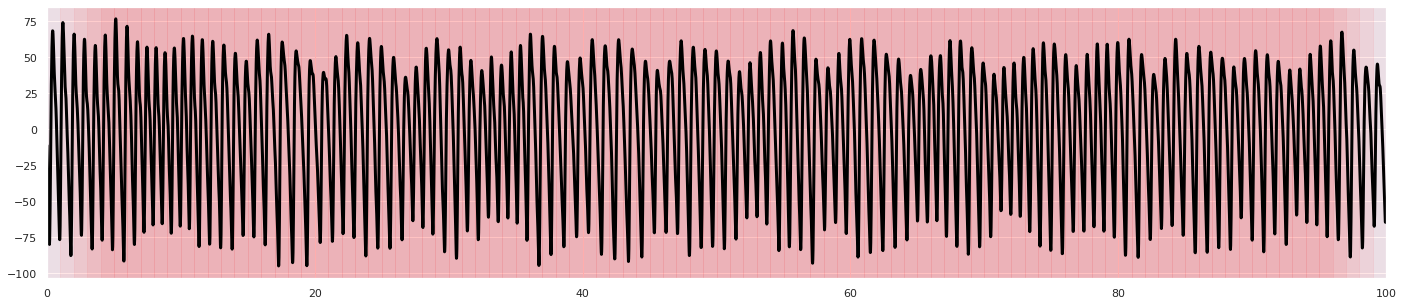

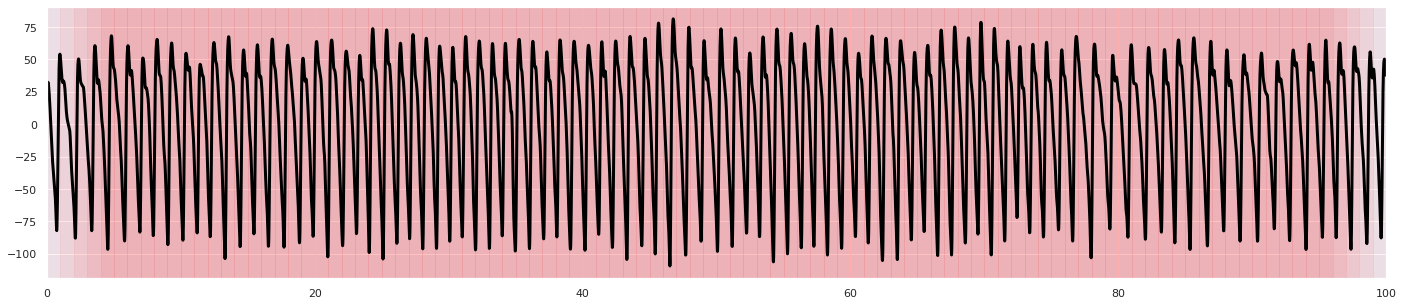

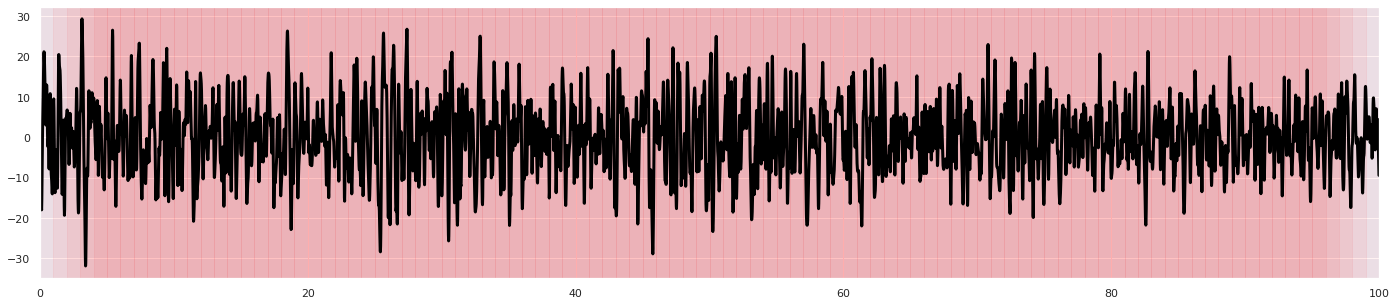

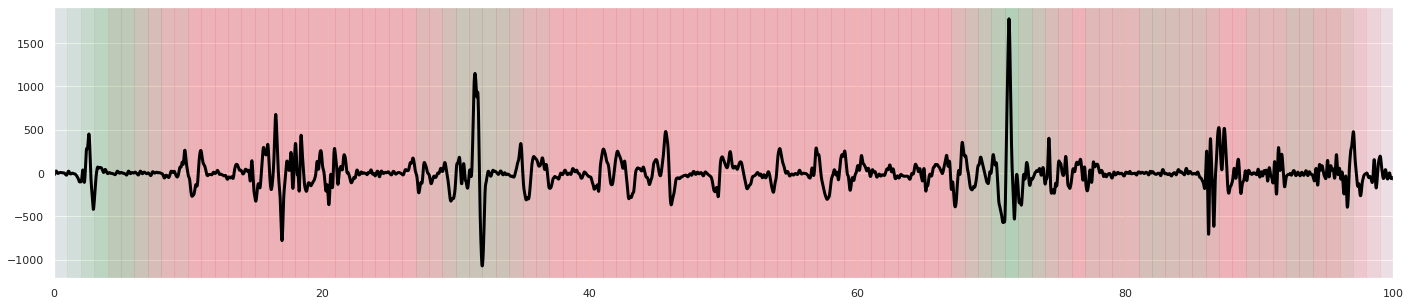

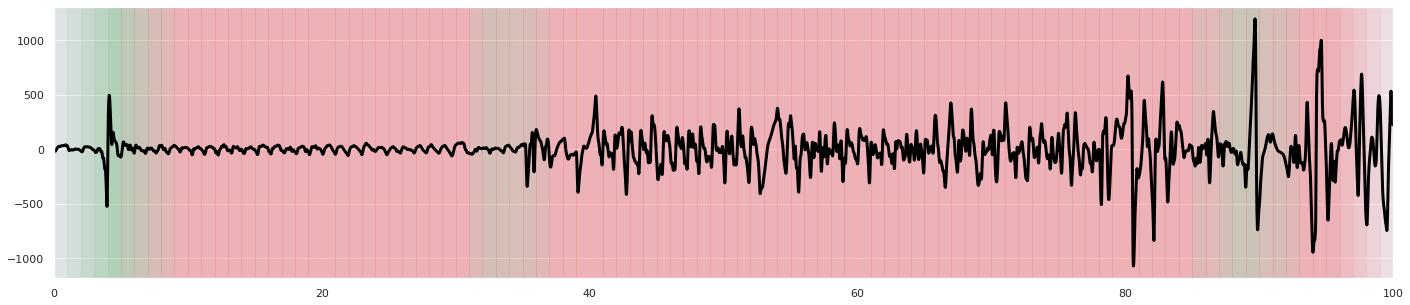

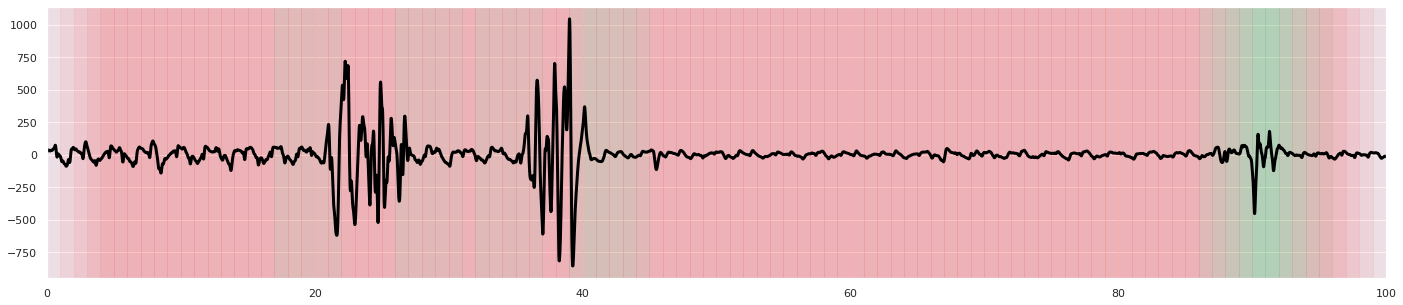

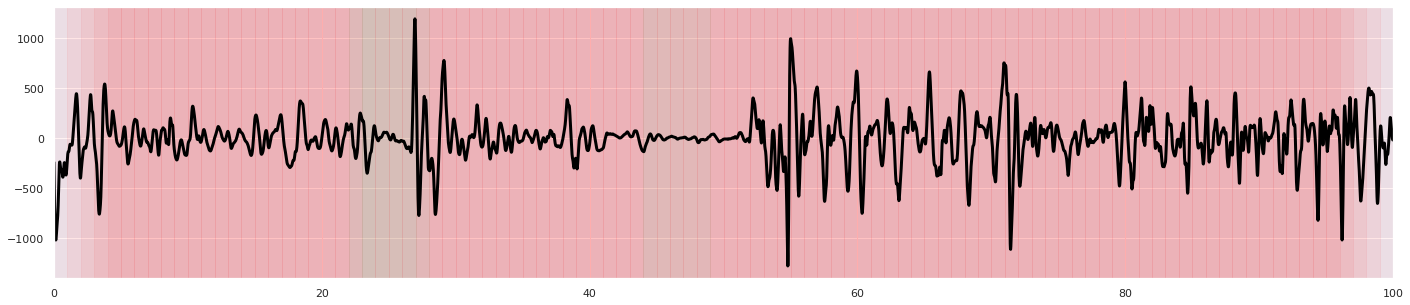

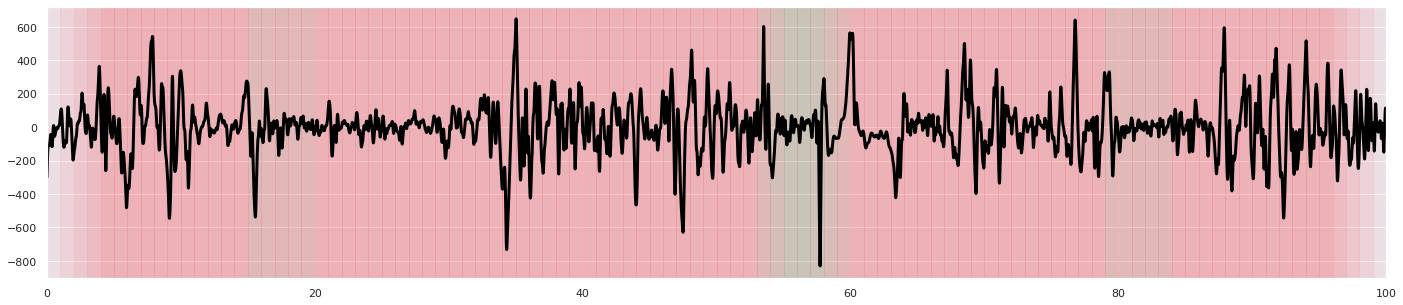

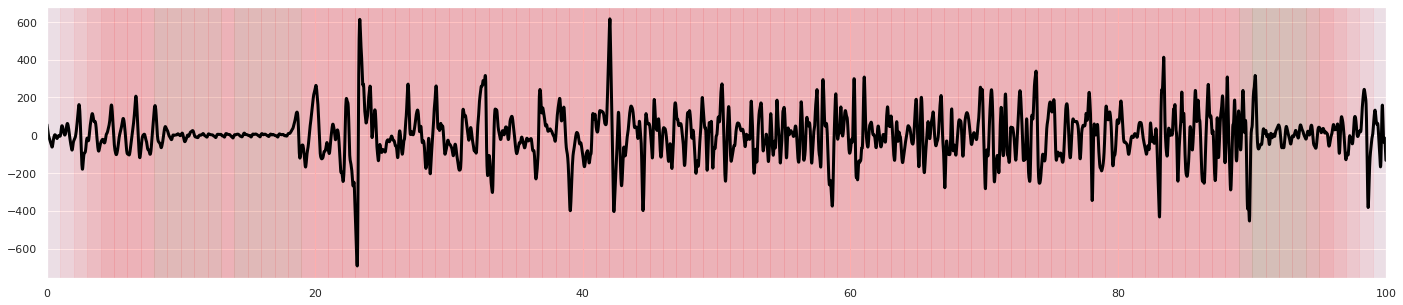

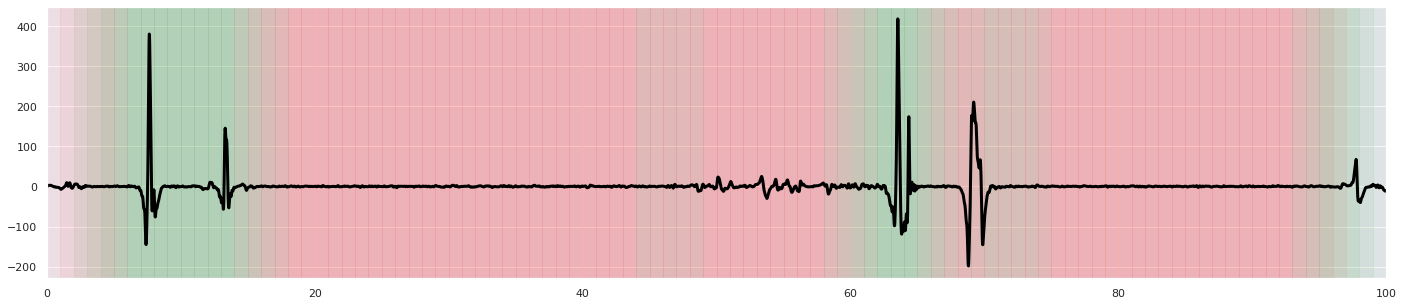

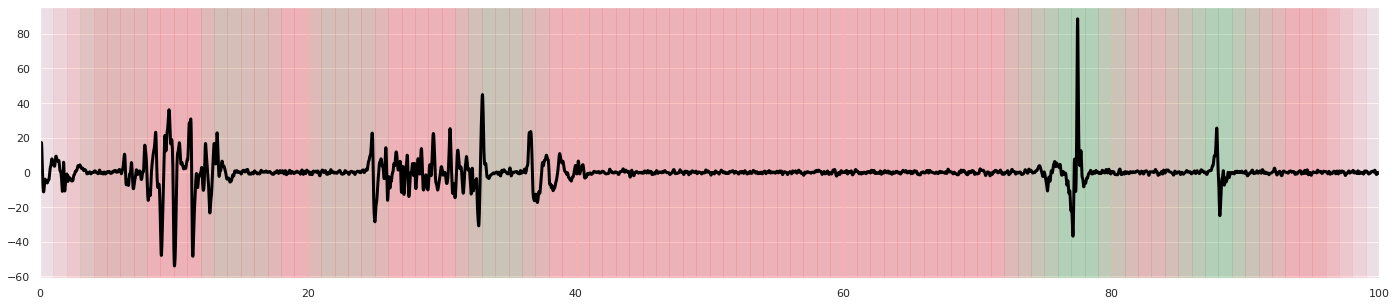

In [12]:
figs = []

for signal in example_signals:
    fig = rate_signal(signal, signal_qality_model, plot=True)
    figs.append(fig)
    
save_figs_to_pdf(*figs, path='examples_labeled_by_quality_model.pdf')

---
# **Signal quality model evaluation**

In [13]:
train_df, test_df = train_test_split(features_df.dropna(), test_size=0.2)

X_train = train_df.drop('label', axis=1).values
X_test = test_df.drop('label', axis=1).values

y_train = train_df['label'].values
y_test = test_df['label'].values

# model = RandomForestClassifier()
model = FuzzyQualityModel()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.6.3 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

 * Detected Sugeno model type


In [15]:
X_test

array([[ 8.50166712e-01, -3.46131506e-02,  2.44743655e-01, ...,
         1.60700862e-01,  3.07104492e-01,  1.96447421e-01],
       [ 3.14076127e+01,  3.81227105e+00,  4.23760444e+01, ...,
         3.52235085e-01,  5.57871094e-01,  3.53332501e-01],
       [ 1.23985588e+00,  2.64066750e-01,  5.10769418e+00, ...,
         9.55615401e-02,  2.52475962e-01,  1.20371128e-01],
       ...,
       [ 1.50630551e+00, -9.46449365e-01,  1.28583520e+01, ...,
         1.61766565e-01,  3.05408266e-01,  1.69981231e-01],
       [ 1.61598298e+02, -1.35786513e+00,  4.68488611e+00, ...,
         2.94177986e-01,  6.43333333e-01,  3.03908447e-01],
       [ 6.39549880e+00,  2.76065876e+00,  1.55419207e+01, ...,
         3.07708368e-01,  4.05572917e-01,  2.49984825e-01]])

In [16]:
acc = accuracy_score(y_test, y_pred)
fscore = f1_score(y_test, y_pred, average='macro')

print(f"Metrics:\n accuracy = {acc:.2f}\n fscore_macro = {fscore:.2f}")

Metrics:
 accuracy = 0.47
 fscore_macro = 0.21


In [17]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
conf_matrix = pd.DataFrame(conf_matrix, index=LABELS.keys(), columns=LABELS.keys())

<AxesSubplot:>

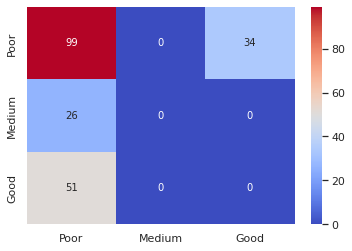

In [18]:
sns.heatmap(conf_matrix, cmap='coolwarm', annot=True, fmt='g')

/home/jslowik/.pyenv/versions/3.8.13/envs/fuzzy_bvp_labeler/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

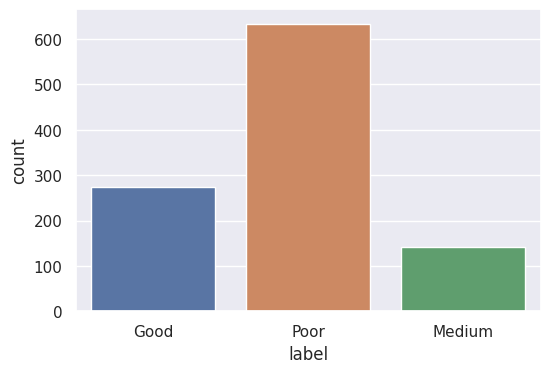

In [68]:
sns.countplot(results['label'])